# Introduction to working with NIX

For an online introduction please see the [nixio readthedocs page](https://nixio.readthedocs.io). This introduction closely follows the introduction presented there.

This notebook is setup to be used with Python 3(.6+). Also to properly run this notebook the following libraries need to be installed:
- `pip install numpy`
- `pip install matplotlib`
- `pip install nixio==1.5.0b3`

Note: nixio 1.5.0b3 is a beta release with many new exciting features of NIX. As of the time of the presentation (24.07.2019) these features have not made it into the main NIX release. So if you are using this notebook at a later point in time, installing via `pip install nixio` should be enough.

## Storing data

When storing data, we have two main requirements:

1. We want to be able to store n-dimensional data structures.
2. The data structures must be self-explanatory, that is, they must contain sufficient information to draw a basic plot of the data.

![](https://nixio.readthedocs.io/en/latest/_images/regular_sampled.png)

Considering the simple plot above, we can list all information that it shows and by extension, that needs to be stored in order to reproduce it.

- the data (voltage measurements)
- the y-axis labeling, i.e. label (voltage) and unit (mV)
- the x-axis labeling, i.e. label (time) and unit (s)
- the x-position for each data point
- a title/legend

In this, and in most cases, it would be inefficient to store x-, and y-position for each data point. The voltage measurements have been done in regular (time) intervals. Thus, we rather need to store the measured values and a definition of the x-axis consisting of an offset, the sampling interval, a label, and a unit.

This is exactly the approach chosen in NIX. For each dimension of the data a dimension descriptor must be given. In NIX we define three (and a half) dimension descriptors:

1. SampledDimension: Used if a dimension is sampled at regular intervals.
- RangeDimension: Used if a dimension is sampled at irregular intervals.
- There is a special case of the RangeDimension, the AliasRangeDimension, which is used when e.g. event times are stored.
- SetDimension: Used for dimensions that represent categories rather than physical quantities.


## Some data to store

Before we can store any data we need to have it lying around somewhere. Lets re-create the example data for the figure we saw above and then see, how we can store this data in a NIX file.

In [13]:
# Lets create some example data:
import numpy as np

freq = 5.0;
samples = 1000
sample_interval = 0.001
time = np.arange(samples)
voltage = np.sin(2 * np.pi * time * freq/samples)


<IPython.core.display.Javascript object>


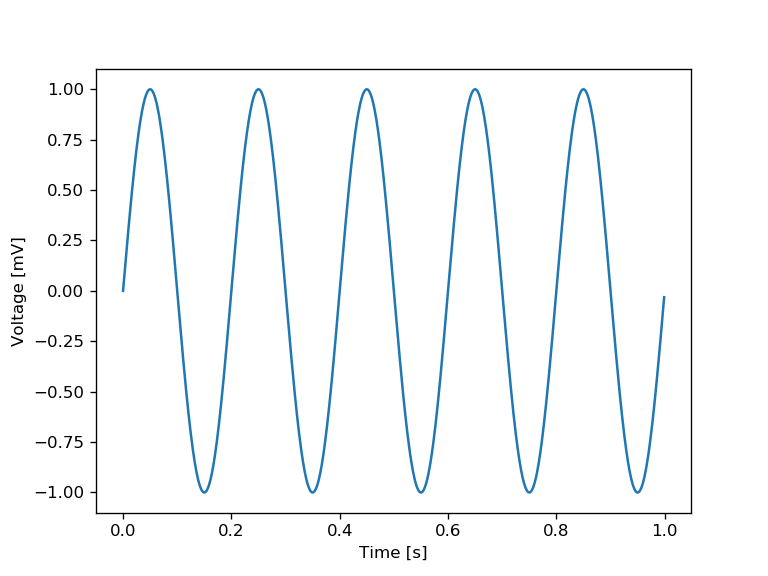

In [14]:
# Lets quickly check how the data we will store actually looks like
# The next line is jupyter notebook specific and will allow us to see plots. It only works in python3.
%matplotlib notebook

import matplotlib.pyplot as plot

plot.plot(time*sample_interval, voltage)
plot.xlabel('Time [s]')
plot.ylabel('Voltage [mV]')

plot.show()


This is perfect data, we would like to keep it and store it in a file. So lets persist this wonderful data in a NIX file.

## The DataArray

The DataArray is the most central entity of the NIX data model. As almost all other NIX-entities it requires a name and a type. Both are not restricted but names must be unique inside a Block. type information can be used to introduce semantic meaning and domain-specificity. Upon creation, a unique ID will be assigned to the DataArray.

The DataArray stores the actual data together with label and unit. In addition, the DataArray needs a dimension descriptor for each dimension. The following snippet shows how to create a DataArray and store data in it.

In [17]:
import nixio

# First create a file we'll use to work with
f = nixio.File.open('Tutorial.nix', nixio.FileMode.Overwrite)

# Please note, that nix works on an open file and reads and writes directly from this file.
# Always close the file using 'f.close()' when you are done.


As you can see in the NIX data model above, NIX files are hierarchically structured. Data is stored in 'DataArrays'. DataArrays are contained in 'Blocks'. When we want to create a DataArray, we need to create at least one Block first, that will contain the DataArray.

In [20]:
# Lets check the blocks we currently have defined in our file; it should be emtpy
f.blocks


[]

In [23]:
# Lets see how we can create a block in our file; we'll use the handy python help function to get more information
help(f.create_block)


Help on method create_block in module nixio.file:

create_block(name, type_, compression=<Compression.Auto: 'Auto'>) method of nixio.file.File instance
    Create a new block inside the file.
    
    :param name: The name of the block to create.
    :type name: str
    :param type_: The type of the block.
    :type type_: str
    :param compression: No, DeflateNormal, Auto (default: Auto)
    
    :returns: The newly created block.
    :rtype: Block



In [39]:
# "name" and "type" of a block can be used to filter and find our blocks later on when the file contains more content
block = f.create_block(name="experimentA", type_="projectA")

# Please note at this point, that the 'name' of any NIX entity e.g. Blocks, DataArrays, etc. has to be unique
# since it can be used to find and return this exact entity via the 'name'.
# The 'type' can also be used to find entities, but it does not need to be unique. You can use 'name' to uniquely
# identify a particular entity and use 'type' to find groups of related entities

In [26]:
# Great, we have an empty block
block

Block: {name = demo_block, type = demo, id = 090373a6-8a63-420a-9127-7036cdbb5f98}

In [27]:
f.blocks

[Block: {name = demo_block, type = demo, id = 090373a6-8a63-420a-9127-7036cdbb5f98}]

In [33]:
# First lets check how we can actually create a DataArray
help(block.create_data_array)

Help on method create_data_array in module nixio.block:

create_data_array(name, array_type, dtype=None, shape=None, data=None, compression=<Compression.Auto: 'Auto'>) method of nixio.block.Block instance
    Create a new data array for this block. Either ``shape``
    or ``data`` must be given. If both are given their shape must agree.
    If ``dtype`` is not specified it will default to 64-bit floating
    points.
    
    :param name: The name of the data array to create.
    :type name: str
    :param array_type: The type of the data array.
    :type array_type: str
    :param dtype: Which data-type to use for storage
    :type dtype:  :class:`numpy.dtype`
    :param shape: Layout (dimensionality and extent)
    :type shape: tuple of int or long
    :param data: Data to write after storage has been created
    :type data: array-like data
    :param compression: En-/disable dataset compression.
    :type compression: :class:`~nixio.Compression`
    
    :returns: The newly created d

In [11]:
# Now we create the DataArray within the Block created above and with the data
# We also add the appropriate labels immediately.

da = block.create_data_array(name="sinedata", array_type="sine", data=voltage)
da.label = "voltage"
da.unit = "mV"

NameError: name 'block' is not defined

In [40]:
# Now we will also add the appropriate Dimension to this DataArray, so it can be correctly interpreted for
# later plotting. We will look into the different Dimensions in a second.

# First we check how to properly create the Dimension we need
help(da.append_sampled_dimension)

Help on method append_sampled_dimension in module nixio.data_array:

append_sampled_dimension(sampling_interval, label=None, unit=None, offset=None) method of nixio.data_array.DataArray instance
    Append a new SampledDimension to the list of existing dimension
    descriptors.
    
    :param sampling_interval: The sampling interval of the SetDimension
                              to create.
    :type sampling_interval: float
    
    :returns: The newly created SampledDimension.
    :rtype: SampledDimension



In [42]:
# And lets add it to our DataArray, again with 
dim = da.append_sampled_dimension(interval)
dim.label = "time"
dim.unit = "s"

In the example shown above, the NIX library will figure out the dimensionality of the data, the shape of the data and its type. The data type and the dimensionality (i.e. the number of dimensions) are fixed once the DataArray has been created. The actual size of the DataArray can be changed during the life-time of the entity.

In case you need more control, DataArrays can be created empty for later filling e.g. during data acquisition.

In [ ]:
# And finally we close our file.
f.close()